# Challenges - Preprocessing
1. Take reasonable steps to mitigate multicolinearity.
2. Check whether we have met each of the 4 assumptions behind linear regression.
3. If we have not met some of these assumption, is there anything (preferably something simple) that we can do to make sure we do satisfy them? If so, try to implement it.
4. How do you know that you have the correct hyperparemeter k when using k-means? Try using the Elbow method.
5. Can you improve the regression performance by incorporating the clustering results as an additional feature?
6. Can you linearly interpolate across the principal components, reconstructing the corresponding images? What do you notice?



In [8]:
import pandas as pd # for manipulating tabular data
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for user friendly visualisation
import numpy as np # for numerical python functionality

from sklearn.linear_model import LinearRegression # implementation of linear regression
from sklearn.model_selection import train_test_split # for creating a train and test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # for evaluating our model

In [31]:
# ----------------------------------------------------------
# Read and pre-process data
# ----------------------------------------------------------
# Read the data from the csv file into a pandas dataframe 
houses = pd.read_csv('Houseprices.csv')

# Select numerical values for num
houses_num = houses.select_dtypes(include = 'number')

# ----------------------------------------------------------
# Deal with missing values
# ----------------------------------------------------------
# Drop Lot Frontage whicch has the highest missing values
# houses_num.isna().sum().sort_values(ascending=False).head()
houses_num = houses_num.drop('LotFrontage', axis=1)
# Drop all rows containing the remaining missing values 
houses_num = houses_num.dropna()


In [32]:
# ----------------------------------------------------------
# Select the features
# ----------------------------------------------------------

# Select the 9 most highly correlated parameters to be our features- excluding itself
X = houses_num[houses_num.corr()['SalePrice'].abs().sort_values(ascending = False)[1:10].index.to_list()]
# Target variable
y = houses_num["SalePrice"]


In [49]:
# ----------------------------------------------------------
# Train test split
# ----------------------------------------------------------
# Perform a train-test split
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state = 42)


In [98]:
# ----------------------------------------------------------
# Build the model : Linear Regression
# ----------------------------------------------------------

# instantiate a model
model = LinearRegression()

# fit the model
model.fit(X, y)

# ----------------------------------------------------------
# Predict : Predict the output using the test set
# ----------------------------------------------------------
# Generate predictions for the test set
y_pred = model.predict(X_test)

In [56]:
# ----------------------------------------------------------
# Evaluate the Output
# ----------------------------------------------------------

#  Mean absolute error
mae = mean_absolute_error(y_test,y_pred)

# Mean Squared Error(root)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print( "Errors : ", mae,rmse)

Errors :  24831.669241123953 35678.96924458827


In [58]:
# -------------------------------------------------------------
#  Inference : How much of the data is explained by our model?
# -------------------------------------------------------------
y_inf = model.predict(X)


# Calculate the r2 score
r2_s = r2_score(y, y_inf)
print('R2 Score :', r2_s)

R2 Score : 0.764901178015206


# Mitigate Multicolinearity
Multicolinearity is when your features are highly correlated with one-another (i.e. the magnitude of the correlation coefficient between them is 0.6 or more). It can cause the regression problem to become ill-conditioned, where coefficients/parameters change dramatically in response to small changes in the data. In practice, this results in incorrect and misleading coefficients/parameters

Steps :
- remove highly correlated pairs and check the r2 metric


<AxesSubplot:>

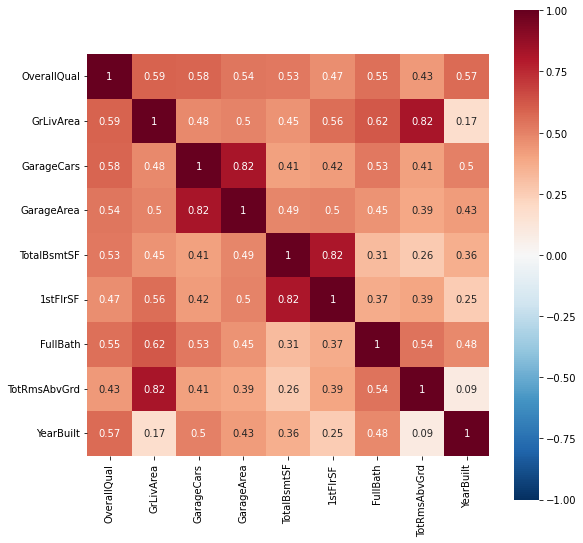

In [60]:
# Visualize correaltions
plt.figure(figsize = (9,9))
# -------------------------------------------------------------
# Heatmap 
# -------------------------------------------------------------
# - correlation matrix
# - set it to square
# - colour
# - range
# - annotation

sns.heatmap(X_train.corr(), square=True, cmap='RdBu_r', vmin=-1,vmax = 1, annot = True)

In [66]:
# Remove the features
X_reduced = X.drop(['GarageArea', 'GrLivArea', 'GrLivArea', '1stFlrSF'], axis = 1)

# Plot the new set of correlations
# plt.figure(figsize=(6,6))
# sns.heatmap(X_reduced.corr(),square=True, cmap='RdBu_r', vmin=-1,vmax = 1, annot = True)



In [67]:
# Instantiate model
model = LinearRegression()

# Fit the model
model.fit(X_reduced, y)

# Predcit the new model
preds = model.predict(X_reduced)


In [69]:
# Check R2 Score
r2_score(preds,y) # the predcition values have not changed much so we dont consider this as an option 

0.6394531541821791

# Assumptions of Linear Regression

- Linear Relationship: There exists a linear relationship between the independent variable, x, and the dependent variable, y.
- Independence: The residuals are independent. In particular, there is no correlation between consecutive residuals in time series data.
- Homoskedasticity : The residuals have constant variance at every level of x.
- Normality: The residuals are normally distributed.

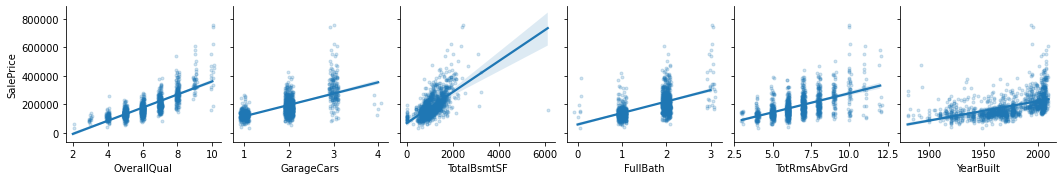

In [72]:
# 1 . LINEARITY : Pairplot 
sns.pairplot(houses_num, x_vars=X_reduced.columns, y_vars=['SalePrice'], markers='.',
             plot_kws={'x_jitter': 0.1, 'y_jitter': 0.1, 'scatter_kws': {'alpha': 0.2}},
             kind='reg')

In [73]:
# 2,3 : INDEPENDENCE AND HOMOSKEDASTICITY

# Calculate the residuals
residuals = y -preds

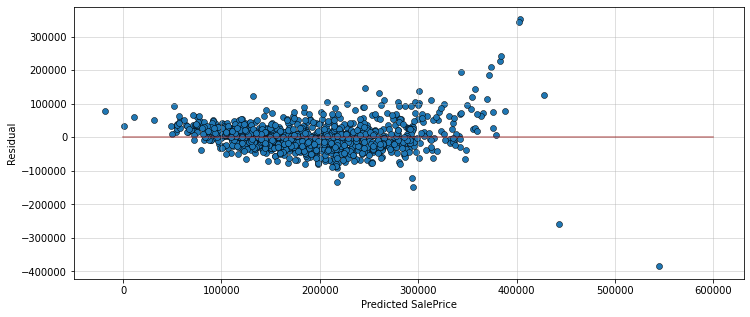

In [74]:
# plot the predicted price vs residuals
plt.figure  (figsize=(12, 5))
plt.scatter(preds, residuals, alpha=1, linewidths=0.5, 
            edgecolors='black')
plt.plot([0,600000],[0,0], color='darkred', alpha=0.5)
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residual')
plt.grid(alpha=0.5)
plt.show()

The plot shows heteroskedasticity at the higher values. There does not seem to be any correlation in the residuals

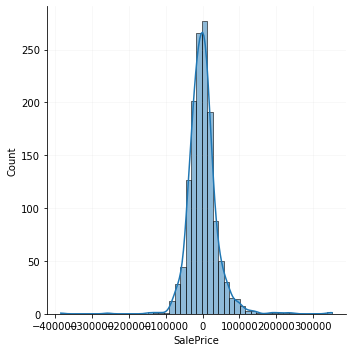

In [86]:
# 4 : NORMALITY
sns.displot(residuals, kde=True, bins=50)
plt.grid(alpha=.1)
plt.show()

The residuals are clearly not normally distributed as this distribution is not symmetrical. It looks as if this could be due to a small number of outliers where the predicted sale price is significantly below the true sale price.

# 3 : Fixing the Problems Identified

## Fixing Heteroskedasticity

- transformation of the dependent variable
- redefine the dependent variable
- weighted least squares which assigns weights to each point based on the variance of its fitted value



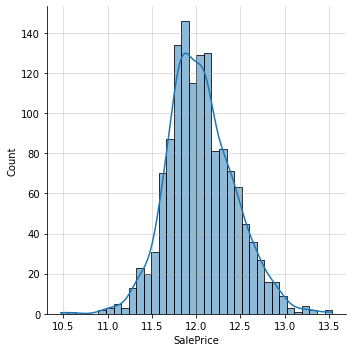

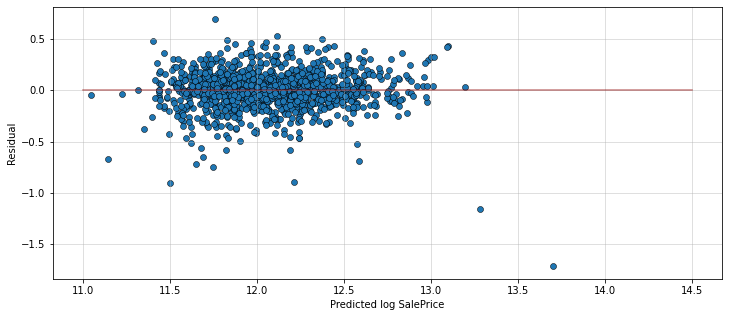

In [92]:
# -----------------------------------------------------------------------------------
# Fixing the heterosketasticity using the first solution to tranforn the dependent variable into a log
# -----------------------------------------------------------------------------------

# take the logarithm of y
log_y = np.log(y)

# -----------------------------------------------------------------------------------
# distribution of target variable
sns.displot(log_y, kde=True)
plt.grid(alpha=0.5)
plt.show()
# -----------------------------------------------------------------------------------
# instantiate model class object
model = LinearRegression()

# fit model to the training set
model.fit(X_reduced, log_y)

# make predictions across the entire dataset
preds = model.predict(X_reduced)
# calculate the residuals
res = log_y - preds
# -----------------------------------------------------------------------------------

# plot predicted sale price vs residuals
plt.figure(figsize=(12, 5))
plt.scatter(preds, res, alpha=1, linewidths=0.5, 
            edgecolors='black')
plt.plot([11, 14.5],[0,0], color='darkred', alpha=0.5)
plt.xlabel('Predicted log SalePrice')
plt.ylabel('Residual')
plt.grid(alpha=0.5)
plt.show()


## Fix Normality

- tranformations on the independent or dependent variable 
- removal of outliers

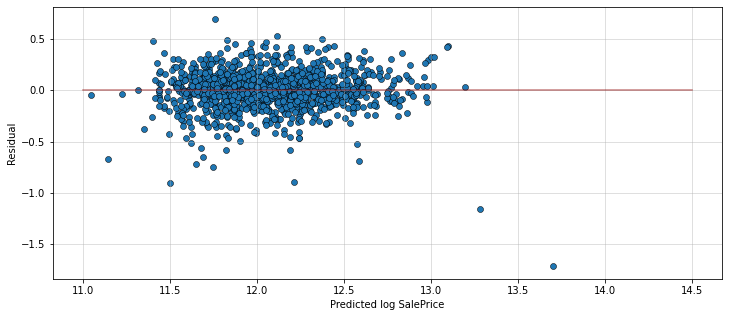

In [97]:
# -----------------------------------------------------------------------------------
# Removal of outliers
# -----------------------------------------------------------------------------------
X_out = X_reduced.drop(residuals[residuals<-0.65].index,axis = 0)
log_y_out = log_y.drop(residuals[residuals<-0.65].index)
# -----------------------------------------------------------------------------------
# instantiate model class object
model = LinearRegression()
# fit model to the training set
model.fit(X_out, log_y_out)
# make predictions across the entire dataset
preds = model.predict(X_out)

# -----------------------------------------------------------------------------------
# calculate the residuals
re = log_y_out - preds
# ----------------------------------------------------------------------------------
# plot predicted sale price vs residuals
plt.figure  (figsize=(12, 5))
plt.scatter(preds, re, alpha=1, linewidths=0.5, 
            edgecolors='black')
plt.plot([11, 14.5],[0,0], color='darkred', alpha=0.5)
plt.xlabel('Predicted log SalePrice')
plt.ylabel('Residual')
plt.grid(alpha=0.5)
plt.show()